# Risk Analysis

In this project, we will conduct risk analysis on four tech giants, Apple, Google, Amazon and Microsoft.

We will extract the past 5 years of data from Yahoo finance, visualize the trend, look at the correlations among each other.

Finally, we will calculated Value at Risk(VaR) by bootstrap method and Monte Carlo simulation with Geometric Brownian Motion(GBM).

In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from datetime import datetime


from pandas_datareader.data import DataReader


In [3]:
# create a list of tech stocks
tech = ['AAPL', 'GOOG', 'AMZN', 'MSFT']

# Extract 5 years of historical data from Yahoo Finance
end_date = datetime.now()
start_date = datetime(end_date.year - 5, end_date.month, end_date.day)

for stock in tech:
    globals()[stock] = DataReader(stock,'yahoo', start_date, end_date)



In [8]:
# Look at AAPL as an example 
# We will use Adjusted Close Price for our analysis
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,66.006162,64.610937,65.296902,65.342929,1.248420e+08,64.137923
std,35.648319,34.715285,35.205359,35.199001,5.736398e+07,35.659716
min,26.430000,25.632500,25.662500,25.782499,4.544800e+07,24.179869
25%,40.478750,39.690001,40.031250,40.007500,8.683445e+07,38.312981
50%,50.247501,49.537498,49.799999,49.875000,1.090120e+08,48.770958
75%,81.101250,79.709999,80.617500,80.521252,1.447678e+08,79.851624
max,151.679993,149.089996,150.229996,151.119995,4.479400e+08,151.119995


In [9]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2016-08-19 to 2021-08-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1259 non-null   float64
 1   Low        1259 non-null   float64
 2   Open       1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Volume     1259 non-null   float64
 5   Adj Close  1259 non-null   float64
dtypes: float64(6)
memory usage: 68.9 KB


## Data Visualization

<AxesSubplot:xlabel='Date'>

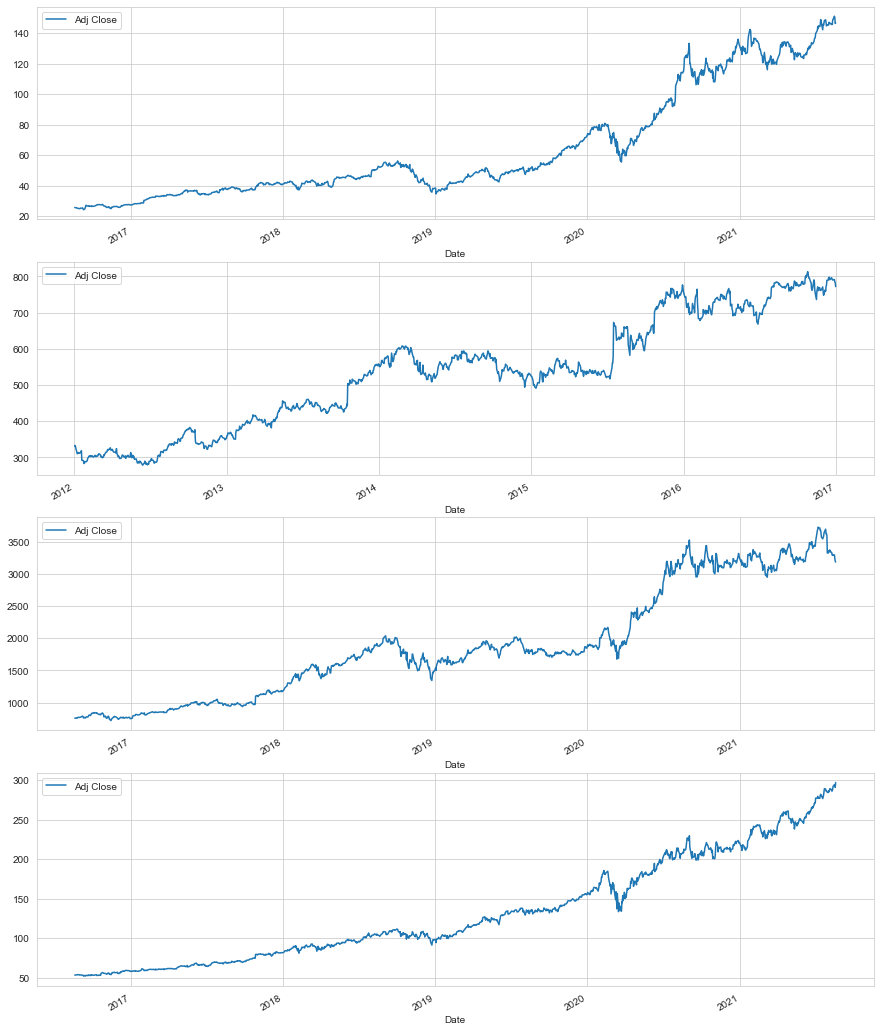

In [205]:
# Let's check the trend of all four stock prices
fig = plt.figure()

ax1 = fig.add_subplot(411)
AAPL['Adj Close'].plot(legend = True, figsize = (15,20))

ax2 = fig.add_subplot(412)
GOOG['Adj Close'].plot(legend = True, figsize = (15,20))

ax3 = fig.add_subplot(413)
AMZN['Adj Close'].plot(legend = True, figsize = (15,20))

ax4 = fig.add_subplot(414)
MSFT['Adj Close'].plot(legend = True, figsize = (15,20))

In [191]:
# Plot the moving averages with 10, 20 and 50 days

moving_avg = [10,20,50]

for ma in moving_avg:
    column_name = 'MA for %s days' %(str(ma))
    # after rolling(), add mean() to get the average
    AAPL[column_name] = AAPL['Adj Close'].rolling(window = ma).mean() 
    GOOG[column_name] = GOOG['Adj Close'].rolling(window = ma).mean() 
    AMZN[column_name] = AMZN['Adj Close'].rolling(window = ma).mean() 
    MSFT[column_name] = MSFT['Adj Close'].rolling(window = ma).mean() 

<AxesSubplot:xlabel='Date'>

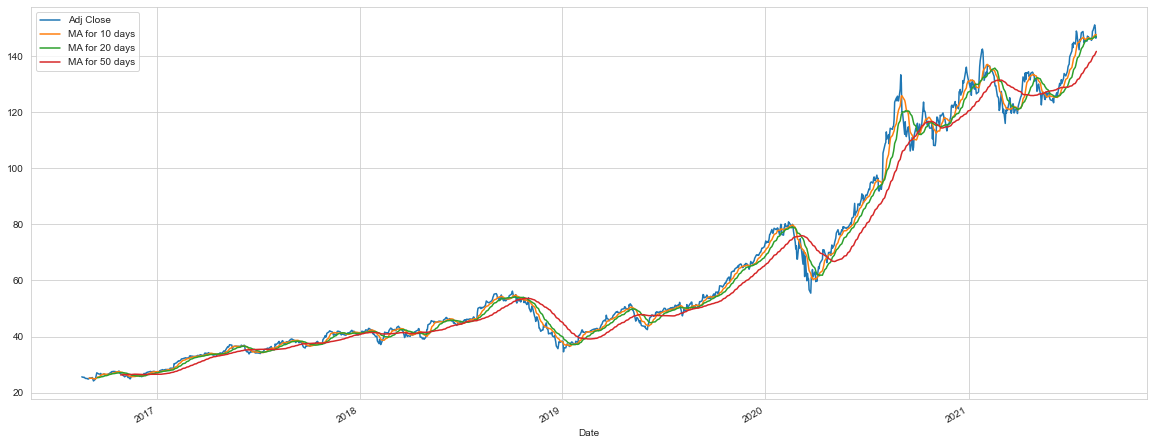

In [67]:
# Apple as an example
AAPL[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(figsize=(20,8))

In [193]:
# Calculate the daily return
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()
AAPL['Daily Return'].dropna()

Date
2016-08-22   -0.007772
2016-08-23    0.003133
2016-08-24   -0.007533
2016-08-25   -0.004258
2016-08-26   -0.005857
                ...   
2021-08-13    0.001410
2021-08-16    0.013548
2021-08-17   -0.006154
2021-08-18   -0.025501
2021-08-19    0.002323
Name: Daily Return, Length: 1258, dtype: float64

C:\Users\ABC\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Daily Return', ylabel='Density'>

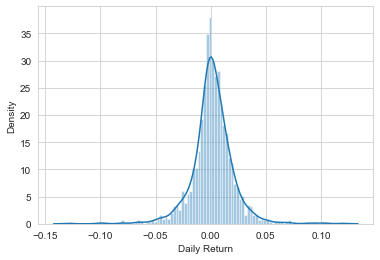

In [76]:
sns.distplot(AAPL['Daily Return'].dropna(), bins=100)

In [77]:
# Get the daily return of all four
adj_prices = DataReader(['AAPL', 'GOOG', 'AMZN', 'MSFT'], 'yahoo', start_date, end_date)['Adj Close']
daily_return_df = adj_prices.pct_change()

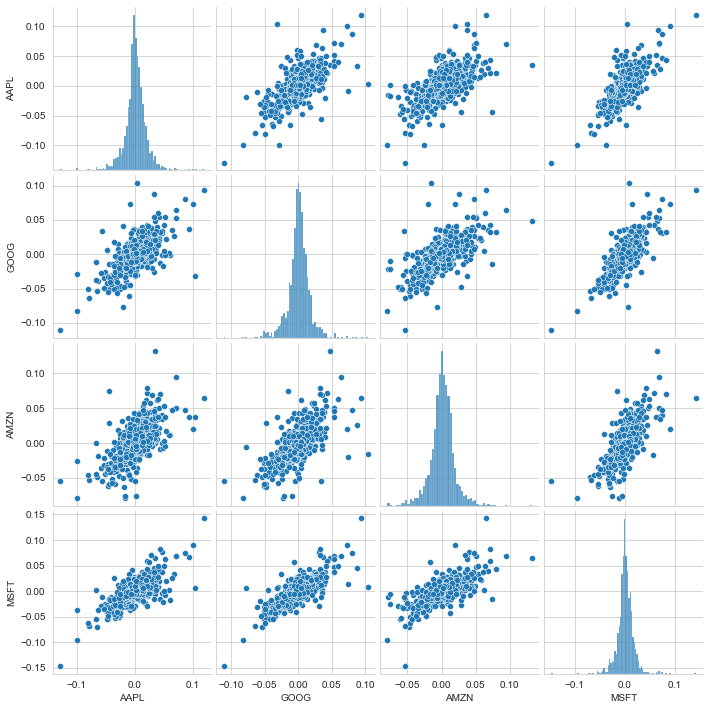

In [95]:
sns.pairplot(daily_return_df.dropna())


They all have pretty high correlations to each other, probably because many of the tech companies in NASDAQ have been growing a lot in recent five years.

## Risk Analysis

Now, we will perfom a risk analysis.

First, calculate the risk and expected return.

Risk can be considered as the standard deviation of the daily return (volatility) and expected return is the expected value of the daily return.

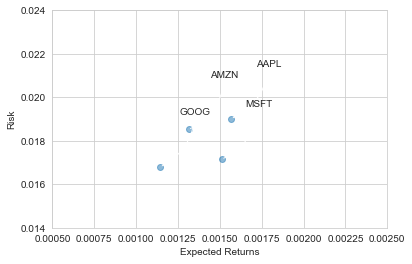

In [113]:
daily_return_df.dropna(inplace = True)
expected_returns = daily_return_df.mean()
risk = daily_return_df.std()

plt.scatter(expected_returns, risk, alpha=0.5)

plt.ylim([0.014,0.024])
plt.xlim([0.0005,0.0025])
plt.xlabel('Expected Returns')
plt.ylabel('Risk')

for label, x, y in zip(daily_return_df.columns, expected_returns, risk):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))


### Bootstrap Method

Bootstrap method is useful for estimating the distribution of a statistic (e.g. mean, variance) without using normal theory.

It can be used here through the following steps.

1. Choose a number of bootstrap samples to perform
2. Choose a sample size
3. For each bootstrap sample
    1. random sample a period (a day) from the historical window with replacement with the chosen size.
    2. Calculate the mean daily return corresponding to those periods.
4. Calculate the mean of the calculated sample statistics (in this case, means of daily return).

C:\Users\ABC\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Daily Return', ylabel='Density'>

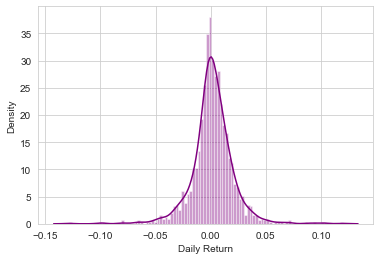

In [138]:
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

The histogram looks normal and we have sufficent amount of data.

Bootstrap method will not be needed and we can simply calculate the quantile to get the Value at Risk.

In [115]:
daily_return_df['AAPL'].quantile(0.05)

-0.027924848498263655

This result implies that we are 95% confident that our worst daily loss won't exceed 2.7%.

For example, if we invest 1 milion dollar on Apple stock, the one-day 5% VaR is 1,000,000*0.0279 = $27,900.

### Monte Carlo Method

Unlike bootstrap method, where we randomized the selection of historical period (day within the histocial window), 
Monte Carlo method has an algorithm(GBM) to which the randomness is applied.

We use Geometric Brownian Motion(GBM) to simulate Monte Carlo method.

$$ \Delta S = S(\mu\Delta t + \sigma \epsilon \sqrt{\Delta t}) $$ 

where the first term is defined as 'drift' and second term is known as 'shock'

We are going to use the expected return ($\mu$) and the risk ($\sigma$) from the previous calculation

In [166]:
# time horizon t. We want a year long horizon. dt is one day 

days = 365

dt = 1/days

mu = expected_returns['AAPL']

sigma = expected_returns['AAPL']

In [181]:
def monte_carlo_simulation(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    # create drift and shock
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in range(1,days):
        
        # calculate the shock
        # notice the epsilon is the random variable sampled from the standard normal distribution.
        shock[x] = np.random.normal(0,1)*sigma*np.sqrt(dt)
        # calculate the drift
        drift[x] = mu * dt
        # calculate the price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [185]:
# Get start price from AAPL.tail()
AAPL.tail()

,High,Low,Open,Close,Volume,Adj Close,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,
2021-08-13,149.440002,148.270004,148.970001,149.100006,59318800.0,149.100006,146.769202,146.355272,139.871058,0.001410
2021-08-16,151.190002,146.470001,148.539993,151.119995,103296000.0,151.119995,147.350970,146.799427,140.379424,0.013548
2021-08-17,151.679993,149.089996,150.229996,150.190002,92229700.0,150.190002,147.656017,147.012360,140.868991,-0.006154
2021-08-18,150.720001,146.149994,149.800003,146.360001,86326000.0,146.360001,147.619000,147.071236,141.265183,-0.025501
2021-08-19,148.000000,144.500000,145.029999,146.699997,86861700.0,146.699997,147.605000,147.077216,141.660387,0.002323


Text(0.5, 1.0, 'Monte Carlo Analysis for Apple')

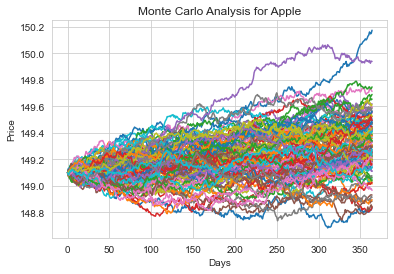

In [187]:
start_price = 149.1

for run in range(100):
    plt.plot(monte_carlo_simulation(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Apple')

In [188]:
runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in range(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = monte_carlo_simulation(start_price,days,mu,sigma)[days-1];


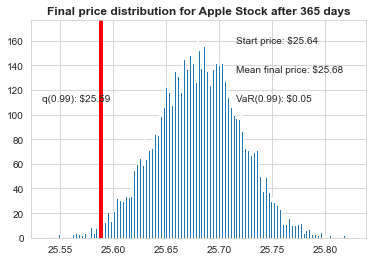

In [184]:
# Now we'll define q as the 1% empirical qunatile, meaning that 99% of the values should fall between here
q = np.percentile(simulations, 1)
    
# Let's plot the distribution of the end prices
plt.hist(simulations,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)

# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for Apple Stock after %s days" % days, weight='bold');

We can conduct the same process for the other tech companies, Google, Amazon and Microsoft.